In [1]:
import tensorflow as tf
import numpy as np

## Explore the dataset

Using TensorFlow backend.


(50000, 28, 28) (50000,)


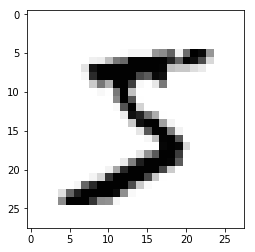

In [2]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [3]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(50000, 28, 28) (50000,)
(10000, 28, 28) (10000,)
(10000, 28, 28) (10000,)


## Preprocess Data

In [4]:
# Flatten
X_train = X_train.reshape([50000, 784])
X_val = X_val.reshape([10000, 784])
X_test = X_test.reshape([10000, 784])

In [5]:
# y_train = np.eye(10)[y_train]
# y_val = np.eye(10)[y_val]
# y_test = np.eye(10)[y_test]

# One hot Encode
import numpy as np
from sklearn import preprocessing

def one_hot_encode(label):
    # Create the encoder
    lb = preprocessing.LabelBinarizer()

    # Here the encoder finds the classes and assigns one-hot vectors 
    lb.fit(label)

    # And finally, transform the labels into one-hot encoded vectors
    return lb.transform(label)

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

In [6]:
y_test.shape

(10000, 10)

## Build Layers

In [7]:
X = tf.placeholder(tf.float32, shape=(None, 784))
Y = tf.placeholder(tf.float32, shape=(None, 10))
keep_prob = tf.placeholder(tf.float32)

In [8]:
# Hidden fully connected layer with 256 neurons
W1 = tf.get_variable("W1",  [784, 256], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable("b1",  [256], initializer=tf.zeros_initializer())

# Hidden fully connected layer with 256 neurons
W2 = tf.get_variable("W2",  [256, 256], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable("b2",  [256], initializer=tf.zeros_initializer())

# Output: 10 classes
W3 = tf.get_variable("W3", [256, 10], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.get_variable("b3",  [10], initializer=tf.zeros_initializer())

In [9]:
# Connections and Calculations
Z1 = tf.add(tf.matmul(X, W1), b1)
A1 = tf.nn.relu(Z1)
A1 = tf.nn.dropout(A1, keep_prob)

Z2 = tf.add(tf.matmul(A1, W2), b2)
A2 = tf.nn.relu(Z2)
A2 = tf.nn.dropout(A2, keep_prob)

Z3 = tf.add(tf.matmul(A2, W3), b3)
A3 = tf.nn.sigmoid(Z3)

## Build Hyperparameters

In [10]:
# Learning rate
starter_learning_rate = 0.00036
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100, 0.85, staircase=True)

# Define cost and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=A3))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Calculate accuracy
predict_op = tf.argmax(Z3, 1)
correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

## Train Model

In [11]:
# Batch process
import math
def batches(batch_size, X, y):

    assert len(X) == len(y)
    output_batches = []
    
    sample_size = len(X)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [X[start_i:end_i], y[start_i:end_i]]
        output_batches.append(batch)
        
    return output_batches

In [12]:
def print_epoch_stats(epoch_i, sess):
    
    current_cost = sess.run(
        cost,
        feed_dict={
            X: X_test,
            Y: y_test,
            keep_prob: 1})
    
    # Calculate validation set accuracy
    valid_accuracy = sess.run(
        accuracy,
        feed_dict={
            X: X_val, 
            Y: y_val,
            keep_prob: 1})

    print('Epoch: {:<4} - Cost: {:<8.3} Validation Accuracy: {:<5.3}'.format(
        epoch_i,
        current_cost,
        valid_accuracy))

In [13]:
# Parameters
batch_size = 500
train_batches = batches(batch_size, X_train, y_train)

epochs = 100
DropOutRate = 0.35

# Trains
init = tf.global_variables_initializer()

costs_train = []
costs_val = []
costs_test = []
with tf.Session() as session:
    session.run(init)

    for epoch in range(epochs):
        for batch_X, batch_y in train_batches:
            # Train
            session.run(
                optimizer, 
                feed_dict={
                    X: batch_X,
                    Y: batch_y,
                    keep_prob: (1.0 - DropOutRate)})
        
        # Print cost and validation accuracy of an epoch
        print_epoch_stats(epoch + 1, session)
    
        # Collect costs for plotting
        costs_train.append(session.run(cost, feed_dict={X:X_train, Y:y_train, keep_prob : 1}))
        costs_val.append(session.run(cost, feed_dict={X:X_val, Y:y_val, keep_prob : 1}))
        costs_test.append(session.run(cost, feed_dict={X:X_test, Y:y_test, keep_prob : 1}))

    # Calculate accuracies
    accuracy_train = session.run(
        accuracy,
        feed_dict={
            X: X_train,
            Y: y_train,
            keep_prob: 1})

    accuracy_test = session.run(
        accuracy,
        feed_dict={
            X: X_test,
            Y: y_test,
            keep_prob: 1})

Epoch: 1    - Cost: 1.62     Validation Accuracy: 0.89 
Epoch: 2    - Cost: 1.56     Validation Accuracy: 0.914
Epoch: 3    - Cost: 1.54     Validation Accuracy: 0.926
Epoch: 4    - Cost: 1.53     Validation Accuracy: 0.937
Epoch: 5    - Cost: 1.52     Validation Accuracy: 0.943
Epoch: 6    - Cost: 1.51     Validation Accuracy: 0.948
Epoch: 7    - Cost: 1.51     Validation Accuracy: 0.951
Epoch: 8    - Cost: 1.51     Validation Accuracy: 0.955
Epoch: 9    - Cost: 1.5      Validation Accuracy: 0.957
Epoch: 10   - Cost: 1.5      Validation Accuracy: 0.96 
Epoch: 11   - Cost: 1.5      Validation Accuracy: 0.962
Epoch: 12   - Cost: 1.5      Validation Accuracy: 0.964
Epoch: 13   - Cost: 1.5      Validation Accuracy: 0.965
Epoch: 14   - Cost: 1.49     Validation Accuracy: 0.966
Epoch: 15   - Cost: 1.49     Validation Accuracy: 0.967
Epoch: 16   - Cost: 1.49     Validation Accuracy: 0.968
Epoch: 17   - Cost: 1.49     Validation Accuracy: 0.969
Epoch: 18   - Cost: 1.49     Validation Accuracy

## Evaluate

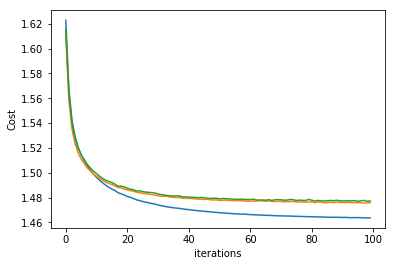

In [14]:
iterations = list(range(epochs))
plt.plot(iterations, costs_train, label='Train')
plt.plot(iterations, costs_val, label='Validation')
plt.plot(iterations, costs_test, label='Test')
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.show()

In [15]:
print("Train Accuracy:", accuracy_train)
print("Test Accuracy:", accuracy_test)

Train Accuracy: 0.9975
Test Accuracy: 0.9816
